# Instance Segmentation using YOLO11-seg

This notebook demonstrates instance segmentation using Ultralytics YOLO11-seg.

**Objectives:**
- Precisely delineate pixel-level boundaries of each person
- Extract and visualize individual segmentation masks
- Calculate mask areas and extract contours/polygons
- Export masks in various formats

**Model:** YOLO11s-seg (small variant - optimized for CPU)

## 1. Setup & Installation

In [ ]:
# Install required packages (run once)
# !pip install ultralytics opencv-python matplotlib pandas tqdm

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from pathlib import Path
from tqdm import tqdm
import json

from ultralytics import YOLO

# Set up paths
PROJECT_ROOT = Path("../")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "segmentations"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load YOLO11s-seg model (will download automatically on first run)
model = YOLO("yolo11m-seg.pt")

# Print model info
print(f"Model: {model.model_name}")
print(f"Task: {model.task}")
print(f"\nThis model can output both bounding boxes AND segmentation masks!")

Model: yolo11m-seg.pt
Task: segment

This model can output both bounding boxes AND segmentation masks!


## 2. Download Sample Images

In [3]:
# Download sample images for testing
import urllib.request

sample_images = {
    "bus.jpg": "https://ultralytics.com/images/bus.jpg",
    "zidane.jpg": "https://ultralytics.com/images/zidane.jpg"
}

images_dir = DATA_DIR / "images"
images_dir.mkdir(parents=True, exist_ok=True)

for filename, url in sample_images.items():
    filepath = images_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
        print(f"  Saved to {filepath}")
    else:
        print(f"{filename} already exists")

print("\nSample images ready!")

bus.jpg already exists
zidane.jpg already exists

Sample images ready!


## 3. Single Image Segmentation

In [4]:
def segment_persons(image_path, model, conf_threshold=0.25):
    """
    Segment persons in an image using YOLO11-seg.
    
    Args:
        image_path: Path to input image
        model: YOLO-seg model instance
        conf_threshold: Confidence threshold (0-1)
    
    Returns:
        results: Segmentation results
        segments: List of segment dictionaries with masks
    """
    # Run segmentation (class 0 = person in COCO)
    results = model.predict(
        source=image_path,
        classes=[0],  # Only segment persons
        conf=conf_threshold,
        verbose=False
    )
    
    segments = []
    result = results[0]
    
    if result.masks is not None:
        masks = result.masks.data.cpu().numpy()  # (N, H, W)
        boxes = result.boxes
        
        for i, (mask, box) in enumerate(zip(masks, boxes)):
            # Get mask contours
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Calculate mask area
            mask_area = np.sum(mask > 0.5)
            
            segment = {
                "id": i,
                "class": "person",
                "confidence": float(box.conf[0]),
                "bbox_xyxy": box.xyxy[0].tolist(),
                "mask": mask,  # Binary mask (H, W)
                "mask_area_pixels": int(mask_area),
                "contours": contours
            }
            segments.append(segment)
    
    return results, segments

In [5]:
# Run segmentation on sample image
image_path = DATA_DIR / "images" / "bus.jpg"
results, segments = segment_persons(image_path, model)

print(f"Segmented {len(segments)} person(s)")
print("\nSegmentation details:")
for seg in segments:
    print(f"  Person {seg['id']}:")
    print(f"    Confidence: {seg['confidence']:.2f}")
    print(f"    Mask area: {seg['mask_area_pixels']:,} pixels")
    print(f"    Contours: {len(seg['contours'])} polygon(s)")

Segmented 4 person(s)

Segmentation details:
  Person 0:
    Confidence: 0.92
    Mask area: 18,248 pixels
    Contours: 1 polygon(s)
  Person 1:
    Confidence: 0.91
    Mask area: 8,415 pixels
    Contours: 1 polygon(s)
  Person 2:
    Confidence: 0.89
    Mask area: 12,891 pixels
    Contours: 1 polygon(s)
  Person 3:
    Confidence: 0.79
    Mask area: 4,556 pixels
    Contours: 1 polygon(s)


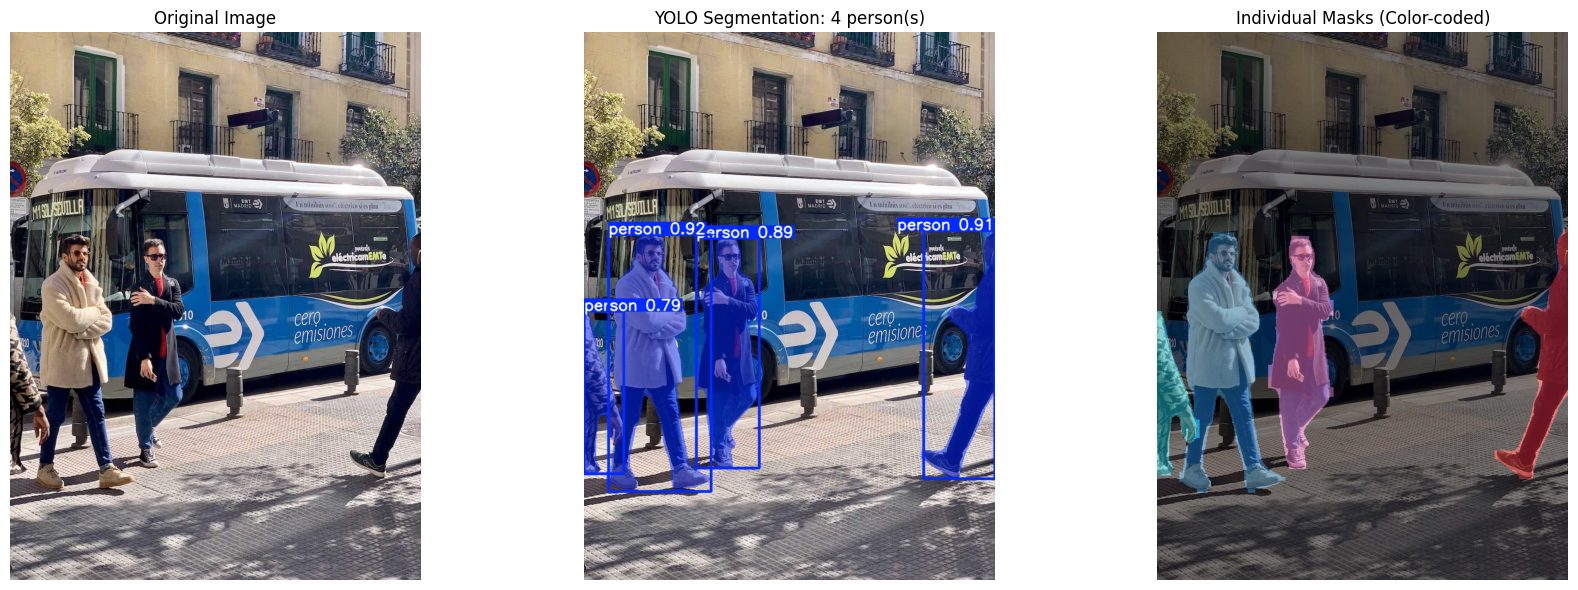

In [7]:
# Display segmentation results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
original = cv2.imread(str(image_path))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis('off')

# YOLO annotated output (boxes + masks)
annotated = results[0].plot()
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
axes[1].imshow(annotated)
axes[1].set_title(f"YOLO Segmentation: {len(segments)} person(s)")
axes[1].axis('off')

# Individual masks visualization
combined_mask = np.zeros((*original.shape[:2], 3), dtype=np.float32)
colors = plt.cm.tab10(np.linspace(0, 1, max(len(segments), 1)))[:, :3]

for i, seg in enumerate(segments):
    mask = seg['mask']
    color = colors[i % len(colors)]
    if mask.shape[:2] != original.shape[:2]:
        mask = cv2.resize(mask, (original.shape[1], original.shape[0]))
    for c in range(3):
        combined_mask[:, :, c] += mask * color[c]

# Blend with original
blended = (original / 255.0 * 0.5 + combined_mask * 0.5)
blended = np.clip(blended, 0, 1)
axes[2].imshow(blended)
axes[2].set_title("Individual Masks (Color-coded)")
axes[2].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "segmentation_overview.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. Mask Operations

In [8]:
def extract_mask_info(segment, original_shape):
    """
    Extract detailed information from a segmentation mask.
    
    Args:
        segment: Segment dictionary with mask
        original_shape: Shape of original image (H, W, C)
    
    Returns:
        info: Dictionary with mask information
    """
    mask = segment['mask']
    
    # Calculate centroid
    coords = np.argwhere(mask > 0.5)
    if len(coords) > 0:
        centroid_y = np.mean(coords[:, 0])
        centroid_x = np.mean(coords[:, 1])
    else:
        centroid_y = centroid_x = 0
    
    # Calculate bounding box from mask
    if len(coords) > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
    else:
        y_min = x_min = y_max = x_max = 0
    
    # Calculate area percentage
    total_pixels = original_shape[0] * original_shape[1]
    area_percentage = (segment['mask_area_pixels'] / total_pixels) * 100
    
    # Get polygon points from largest contour
    polygon_points = []
    if segment['contours']:
        largest_contour = max(segment['contours'], key=cv2.contourArea)
        # Simplify contour
        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        polygon_points = approx.reshape(-1, 2).tolist()
    
    return {
        "id": segment['id'],
        "mask_area_pixels": segment['mask_area_pixels'],
        "area_percentage": area_percentage,
        "centroid": (centroid_x, centroid_y),
        "mask_bbox": (x_min, y_min, x_max, y_max),
        "polygon_points": polygon_points,
        "num_polygon_points": len(polygon_points)
    }

In [9]:
# Extract mask information for all segments
original = cv2.imread(str(image_path))
mask_infos = []

print("Mask Analysis:")
print("=" * 60)
for seg in segments:
    info = extract_mask_info(seg, original.shape)
    mask_infos.append(info)
    
    print(f"\nPerson {info['id']}:")
    print(f"  Area: {info['mask_area_pixels']:,} pixels ({info['area_percentage']:.2f}% of image)")
    print(f"  Centroid: ({info['centroid'][0]:.1f}, {info['centroid'][1]:.1f})")
    print(f"  Mask BBox: x=[{info['mask_bbox'][0]}, {info['mask_bbox'][2]}], y=[{info['mask_bbox'][1]}, {info['mask_bbox'][3]}]")
    print(f"  Polygon: {info['num_polygon_points']} points")

Mask Analysis:

Person 0:
  Area: 18,248 pixels (2.09% of image)
  Centroid: (76.3, 384.9)
  Mask BBox: x=[26, 149], y=[234, 537]
  Polygon: 13 points

Person 1:
  Area: 8,415 pixels (0.96% of image)
  Centroid: (453.3, 392.9)
  Mask BBox: x=[394, 479], y=[230, 521]
  Polygon: 11 points

Person 2:
  Area: 12,891 pixels (1.47% of image)
  Centroid: (167.1, 370.3)
  Mask BBox: x=[130, 205], y=[238, 509]
  Polygon: 13 points

Person 3:
  Area: 4,556 pixels (0.52% of image)
  Centroid: (15.7, 430.5)
  Mask BBox: x=[0, 49], y=[326, 517]
  Polygon: 8 points


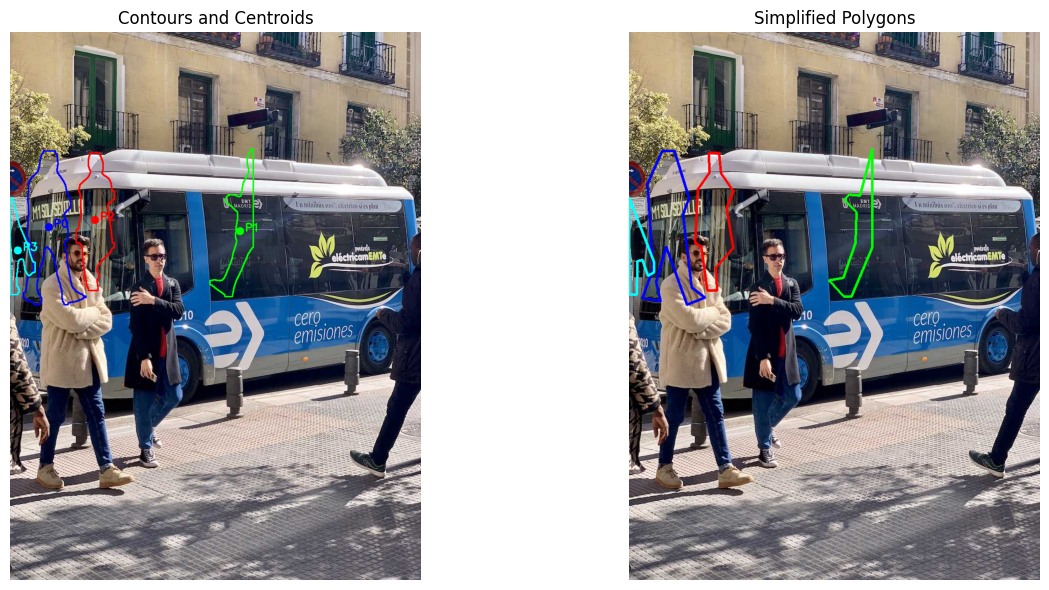

In [10]:
# Visualize contours and centroids
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Image with contours
img_contours = original.copy()
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

for i, seg in enumerate(segments):
    color = colors[i % len(colors)]
    cv2.drawContours(img_contours, seg['contours'], -1, color, 2)
    
    # Draw centroid
    info = mask_infos[i]
    cx, cy = int(info['centroid'][0]), int(info['centroid'][1])
    cv2.circle(img_contours, (cx, cy), 8, color, -1)
    cv2.putText(img_contours, f"P{i}", (cx + 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

img_contours = cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB)
axes[0].imshow(img_contours)
axes[0].set_title("Contours and Centroids")
axes[0].axis('off')

# Simplified polygons
img_polygons = original.copy()
for i, info in enumerate(mask_infos):
    color = colors[i % len(colors)]
    if info['polygon_points']:
        pts = np.array(info['polygon_points'], dtype=np.int32)
        cv2.polylines(img_polygons, [pts], True, color, 3)

img_polygons = cv2.cvtColor(img_polygons, cv2.COLOR_BGR2RGB)
axes[1].imshow(img_polygons)
axes[1].set_title("Simplified Polygons")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "contours_polygons.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Generate Binary Masks

In [11]:
def create_binary_mask(segment, target_shape):
    """
    Create a clean binary mask resized to target shape.
    
    Args:
        segment: Segment dictionary with mask
        target_shape: Target shape (H, W)
    
    Returns:
        binary_mask: Binary mask (0 or 255)
    """
    mask = segment['mask']
    
    # Resize if needed
    if mask.shape[:2] != target_shape:
        mask = cv2.resize(mask.astype(np.float32), (target_shape[1], target_shape[0]))
    
    # Convert to binary
    binary_mask = (mask > 0.5).astype(np.uint8) * 255
    
    return binary_mask

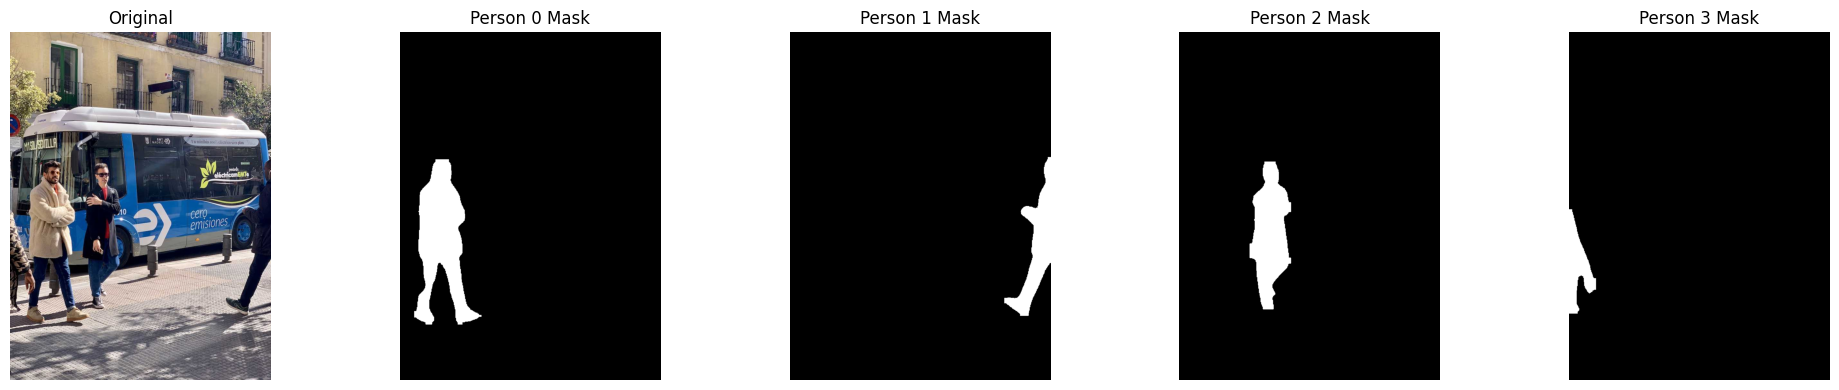

In [12]:
# Display individual binary masks
n_persons = len(segments)
if n_persons > 0:
    fig, axes = plt.subplots(1, n_persons + 1, figsize=(4 * (n_persons + 1), 4))
    if n_persons == 1:
        axes = [axes, axes]  # Handle single person case
    
    # Original image
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    axes[0].imshow(original_rgb)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Individual masks
    for i, seg in enumerate(segments):
        binary_mask = create_binary_mask(seg, original.shape[:2])
        axes[i + 1].imshow(binary_mask, cmap='gray')
        axes[i + 1].set_title(f"Person {i} Mask")
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "binary_masks.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No persons detected to create masks")

## 6. Video Segmentation

In [13]:
def process_video_segmentation(video_path, model, output_path, conf_threshold=0.25):
    """
    Process video with instance segmentation.
    
    Args:
        video_path: Path to input video
        model: YOLO-seg model instance
        output_path: Path to save output video
        conf_threshold: Confidence threshold
    
    Returns:
        frame_stats: List of frame statistics
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing video: {video_path}")
    print(f"  {width}x{height} @ {fps}fps, {total_frames} frames")
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    frame_stats = []
    
    for frame_idx in tqdm(range(total_frames), desc="Segmenting frames"):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run segmentation
        results = model.predict(
            source=frame,
            classes=[0],
            conf=conf_threshold,
            verbose=False
        )
        
        # Get annotated frame
        annotated = results[0].plot()
        out.write(annotated)
        
        # Collect stats
        num_persons = 0
        total_mask_area = 0
        if results[0].masks is not None:
            num_persons = len(results[0].masks)
            masks = results[0].masks.data.cpu().numpy()
            total_mask_area = sum(np.sum(m > 0.5) for m in masks)
        
        frame_stats.append({
            "frame": frame_idx,
            "num_persons": num_persons,
            "total_mask_area": total_mask_area
        })
    
    cap.release()
    out.release()
    
    print(f"Output saved to: {output_path}")
    return frame_stats

Found 1 video(s). Processing first one...
Processing video: ../data/videos/Bangkok.mp4
  1280x720 @ 25fps, 650 frames


Segmenting frames: 100%|██████████| 650/650 [01:55<00:00,  5.64it/s]


Output saved to: ../outputs/segmentations/Bangkok_segmented.mp4


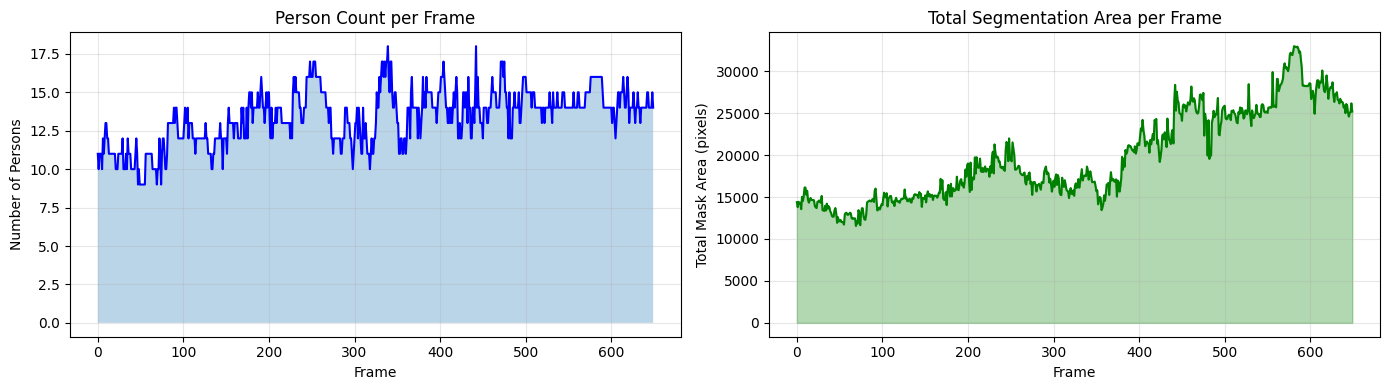

In [14]:
# Check for available videos
video_dir = DATA_DIR / "videos"
video_extensions = [".mp4", ".avi", ".mov", ".mkv"]
videos = [f for f in video_dir.iterdir() if f.suffix.lower() in video_extensions] if video_dir.exists() else []

if videos:
    print(f"Found {len(videos)} video(s). Processing first one...")
    video_path = videos[0]
    output_path = OUTPUT_DIR / f"{video_path.stem}_segmented.mp4"
    
    frame_stats = process_video_segmentation(video_path, model, output_path)
    
    # Plot statistics
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    frames = [s['frame'] for s in frame_stats]
    counts = [s['num_persons'] for s in frame_stats]
    areas = [s['total_mask_area'] for s in frame_stats]
    
    axes[0].plot(frames, counts, 'b-')
    axes[0].fill_between(frames, counts, alpha=0.3)
    axes[0].set_xlabel('Frame')
    axes[0].set_ylabel('Number of Persons')
    axes[0].set_title('Person Count per Frame')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(frames, areas, 'g-')
    axes[1].fill_between(frames, areas, alpha=0.3, color='green')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('Total Mask Area (pixels)')
    axes[1].set_title('Total Segmentation Area per Frame')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "video_segmentation_stats.png", dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No videos found. Add video files to data/videos/ to test video segmentation.")

## 7. Export Masks

In [15]:
def export_masks(segments, original_shape, output_dir, base_name="mask"):
    """
    Export individual masks as PNG files and coordinates as JSON.
    
    Args:
        segments: List of segment dictionaries
        original_shape: Shape of original image (H, W, C)
        output_dir: Directory to save outputs
        base_name: Base name for output files
    
    Returns:
        export_info: Dictionary with export information
    """
    output_dir = Path(output_dir)
    masks_dir = output_dir / "individual_masks"
    masks_dir.mkdir(parents=True, exist_ok=True)
    
    export_info = {
        "image_shape": list(original_shape),
        "num_persons": len(segments),
        "masks": []
    }
    
    for i, seg in enumerate(segments):
        # Save binary mask as PNG
        binary_mask = create_binary_mask(seg, original_shape[:2])
        mask_path = masks_dir / f"{base_name}_person_{i}.png"
        cv2.imwrite(str(mask_path), binary_mask)
        
        # Save mask with alpha channel (RGBA)
        rgba_mask = np.zeros((original_shape[0], original_shape[1], 4), dtype=np.uint8)
        rgba_mask[:, :, :3] = 255  # White foreground
        rgba_mask[:, :, 3] = binary_mask  # Alpha from mask
        rgba_path = masks_dir / f"{base_name}_person_{i}_rgba.png"
        cv2.imwrite(str(rgba_path), rgba_mask)
        
        # Get mask info
        info = extract_mask_info(seg, original_shape)
        
        mask_data = {
            "id": i,
            "mask_file": str(mask_path.name),
            "rgba_file": str(rgba_path.name),
            "confidence": seg['confidence'],
            "area_pixels": info['mask_area_pixels'],
            "area_percentage": info['area_percentage'],
            "centroid": info['centroid'],
            "bbox": info['mask_bbox'],
            "polygon": info['polygon_points']
        }
        export_info["masks"].append(mask_data)
    
    # Save JSON
    json_path = output_dir / f"{base_name}_info.json"
    with open(json_path, 'w') as f:
        json.dump(export_info, f, indent=2)
    
    print(f"Exported {len(segments)} masks to {masks_dir}")
    print(f"Mask info saved to {json_path}")
    
    return export_info

In [ ]:
# Export masks from the sample image
export_info = export_masks(
    segments=segments,
    original_shape=original.shape,
    output_dir=OUTPUT_DIR,
    base_name="bus"
)

# Display export summary
print("\nExport Summary:")
print(f"  Image shape: {export_info['image_shape']}")
print(f"  Persons exported: {export_info['num_persons']}")
for mask in export_info['masks']:
    print(f"\n  Person {mask['id']}:")
    print(f"    Files: {mask['mask_file']}, {mask['rgba_file']}")
    print(f"    Area: {mask['area_pixels']:,} pixels ({mask['area_percentage']:.2f}%)")
    print(f"    Polygon: {len(mask['polygon'])} points")

## 8. Cutout Person (Background Removal)

In [17]:
def cutout_person(image, segment, padding=10):
    """
    Extract a person from the image using their segmentation mask.
    
    Args:
        image: Original image (BGR)
        segment: Segment dictionary with mask
        padding: Padding around bounding box
    
    Returns:
        cutout: RGBA image with transparent background
    """
    mask = segment['mask']
    
    # Resize mask to image size if needed
    if mask.shape[:2] != image.shape[:2]:
        mask = cv2.resize(mask.astype(np.float32), (image.shape[1], image.shape[0]))
    
    # Create binary mask
    binary_mask = (mask > 0.5).astype(np.uint8) * 255
    
    # Create RGBA image
    bgr = image.copy()
    rgba = cv2.cvtColor(bgr, cv2.COLOR_BGR2BGRA)
    rgba[:, :, 3] = binary_mask
    
    # Crop to bounding box with padding
    bbox = segment['bbox_xyxy']
    x1 = max(0, int(bbox[0]) - padding)
    y1 = max(0, int(bbox[1]) - padding)
    x2 = min(image.shape[1], int(bbox[2]) + padding)
    y2 = min(image.shape[0], int(bbox[3]) + padding)
    
    cutout = rgba[y1:y2, x1:x2]
    
    return cutout

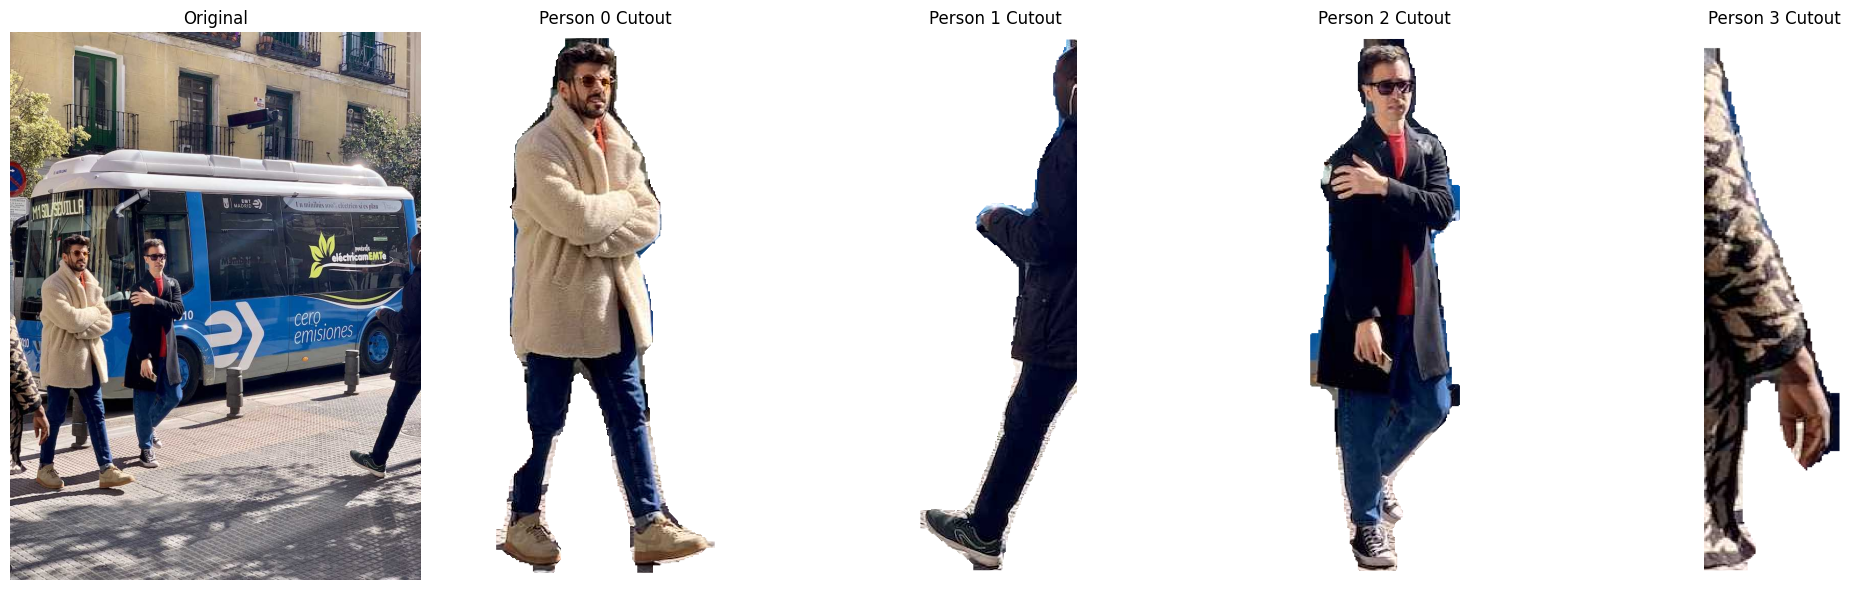


Cutouts saved to ../outputs/segmentations/cutouts


In [18]:
# Create cutouts for all detected persons
if segments:
    fig, axes = plt.subplots(1, len(segments) + 1, figsize=(4 * (len(segments) + 1), 6))
    if len(segments) == 1:
        axes = [axes, axes]
    
    # Original
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Cutouts
    cutouts_dir = OUTPUT_DIR / "cutouts"
    cutouts_dir.mkdir(parents=True, exist_ok=True)
    
    for i, seg in enumerate(segments):
        cutout = cutout_person(original, seg)
        
        # Save cutout
        cutout_path = cutouts_dir / f"person_{i}_cutout.png"
        cv2.imwrite(str(cutout_path), cutout)
        
        # Display (convert BGRA to RGBA for matplotlib)
        cutout_rgb = cv2.cvtColor(cutout, cv2.COLOR_BGRA2RGBA)
        axes[i + 1].imshow(cutout_rgb)
        axes[i + 1].set_title(f"Person {i} Cutout")
        axes[i + 1].axis('off')
        axes[i + 1].set_facecolor('lightgray')  # Show transparency
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "cutouts_preview.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nCutouts saved to {cutouts_dir}")
else:
    print("No persons detected to create cutouts")

## Summary

This notebook demonstrated:
1. **Model Loading**: Using YOLO11s-seg for instance segmentation
2. **Single Image Segmentation**: Extracting person masks
3. **Mask Operations**: Calculating areas, contours, and polygons
4. **Binary Masks**: Creating clean binary masks
5. **Video Segmentation**: Processing video with frame statistics
6. **Mask Export**: Saving masks as PNG and coordinates as JSON
7. **Cutouts**: Background removal for individual persons

**Next Steps:**
- Try `03_person_counting.ipynb` for counting and crowd analysis